# Plotting for the paper

Code to make plots and do some basic analysis for the paper

In [7]:
# imports
import os, glob
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import units as u

from otter import DataFinder

In [8]:
data = pd.read_csv("reduced-photometry.csv")
keys_to_keep = {
    "FILTER" : "Filter",
    "aperture_sum" : "Source Aperture Sum (ADU)",
    "aperture_sum_e" : "Source Aperture Sum (e)",
    "aperture_sum_photons" : "Source Aperture Sum ($\gamma$)",
    "bckgd_adu" : "Background Annulus Sum (ADU)",
    "bckgd_e" : "Background Annulus Sum (e)",
    "bckgd_photons" : "Background Annulus Sum ($\gamma$)",
    "dark_noise_adu" : "Dark Noise ($\sigma_D$; ADU/pixel)",
    "dark_noise_e" : "Dark Noise ($\sigma_D$; e/pixel)",
    "read_noise_adu": "Read Noise ($\sigma_R$; ADU/pixel)",
    "read_noise_e" : "Read Noise ($\sigma_R$; e/pixel)",
    "signal_e" : "Signal ($f_e$; e)",
    "signal_photons" : "Signal ($f_\gamma$; $\gamma$)",
    "SNR" : "SNR",
    "zero_point" : "Zero Point ($10^{12}f_0$; $\gamma$)",
    "mag" : "Apparent Magnitude",
    "mag_err" : "Apparent Magnitude Error"
}

data1 = data.rename(mapper=keys_to_keep, axis=1)
data1[keys_to_keep["zero_point"]] = data1[keys_to_keep["zero_point"]] / 1e12

for_tex = data1[list(keys_to_keep.values())].T
for_tex.columns = for_tex.loc["Filter"]
for_tex = for_tex.drop("Filter")

# Use the Styler object to format the output
styler = for_tex.style.format(formatter='{:.2f}'.format)

print(styler.to_latex(label="tab:res", caption="Reduction Results"))

\begin{table}
\caption{Reduction Results}
\label{tab:res}
\begin{tabular}{lllll}
Filter & Harris-B & Harris-V & Harris-R & Bessell-U \\
Source Aperture Sum (ADU) & 351531.39 & 524268.83 & 554351.81 & 94429.37 \\
Source Aperture Sum (e) & 1089747.30 & 1625233.38 & 1718490.61 & 292731.06 \\
Source Aperture Sum ($\gamma$) & 1814854.11 & 2706647.21 & 2861956.85 & 487511.34 \\
Background Annulus Sum (ADU) & 348945.20 & 522267.83 & 549786.75 & 93693.18 \\
Background Annulus Sum (e) & 1081730.11 & 1619030.28 & 1704338.91 & 290448.86 \\
Background Annulus Sum ($\gamma$) & 1801502.37 & 2696316.62 & 2838388.76 & 483710.59 \\
Dark Noise ($\sigma_D$; ADU/pixel) & 0.29 & 0.29 & 0.29 & 0.29 \\
Dark Noise ($\sigma_D$; e/pixel) & 0.51 & 0.51 & 0.51 & 0.51 \\
Read Noise ($\sigma_R$; ADU/pixel) & 3.04 & 3.04 & 3.04 & 3.04 \\
Read Noise ($\sigma_R$; e/pixel) & 9.41 & 9.41 & 9.41 & 9.41 \\
Signal ($f_e$; e) & 8017.18 & 6203.11 & 14151.70 & 2282.20 \\
Signal ($f_\gamma$; $\gamma$) & 13351.74 & 10330.59 & 2

# Plot the measured magnitudes

with some other data taken from TNS

In [9]:
pos = SkyCoord(
    "05:26:38.320",
    "-17:54:54.68",
    unit=("hourangle", "deg")
)

# From the SVO filter service
atlas_zps = {
    "o" : (3631.00 * u.Jy).to(u.uJy).value,
    "c" : (3733.25 * u.Jy).to(u.uJy).value
}

overwrite = False
data_finder = DataFinder(pos.ra.deg, pos.dec.deg, ra_units="deg", dec_units="deg")

# query ATLAS forced photometry first
if overwrite:
    atlas_phot = data_finder.query_atlas()
    atlas_phot.to_csv("atlas-photometry.csv")
else:
    atlas_phot = pd.read_csv("atlas-photometry.csv")
    
atlas_phot["mag"] = atlas_phot.apply(lambda row : -2.5*np.log10(row.uJy/atlas_zps[row.F]), axis=1)
atlas_phot["mag_err"] = atlas_phot.apply(lambda row : np.abs(np.log(10) / 2.5) * row.duJy/row.uJy, axis=1)
atlas_phot["upperlimit"] = atlas_phot.apply(lambda row : row.uJy < row.duJy*3, axis=1)

# then also query ZTF
if overwrite:
    ztf_phot = data_finder.query_ztf().to_pandas()
    ztf_phot.to_csv("ztf-photometry.csv")
else:
    ztf_phot = pd.read_csv("ztf-photometry.csv")

ztf_phot["upperlimit"] = ztf_phot.apply(lambda row : row.magerr > np.log(10) / (3 * 2.5), axis=1)
ztf_phot.filtercode.unique()

/tmp/ipykernel_43446/2554715903.py:23: RuntimeWarning: invalid value encountered in log10
  atlas_phot["mag"] = atlas_phot.apply(lambda row : -2.5*np.log10(row.uJy/atlas_zps[row.F]), axis=1)


array(['zg', 'zr', 'zi'], dtype=object)

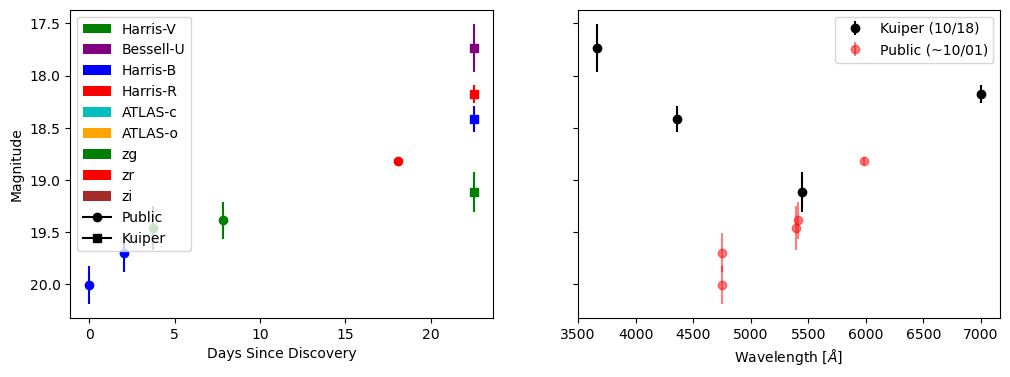

In [10]:

filter_wavelengths = {
    "Harris-V" : 5448, # angstroms
    "Bessell-U": 3663,
    "Harris-B" : 4361,
    "Harris-R" : 7000,
}

tns_factor = 1e14
filter_zps = {
    "Harris-V" : 363.1e-11*tns_factor, # erg cm**-2 s**-1 A**-1
    "Bessell-U": 417.5e-11*tns_factor,
    "Harris-B" : 632e-11*tns_factor,
    "Harris-R" : 217.7e-11*tns_factor
}

color_map = {
    "Harris-V" : "g", # angstroms
    "Bessell-U": "purple",
    "Harris-B" : "b",
    "Harris-R" : "r",
    "ATLAS-c" : "c",
    "ATLAS-o" : "orange",
    "zg" : "g",
    "zr" : "r",
    "zi" : "brown"
}

data["wave"] = [filter_wavelengths[f] for f in data.FILTER]

fig, (ax, ax2) = plt.subplots(1,2,figsize=(12,4),sharey=True)

public_phot = pd.DataFrame(dict(
    mag = [18.82, 19.696, 20.0047, 19.46, 19.387],
    mag_err = [0.04, 0.186, 0.181, 0.21, 0.174],
    wave = [5980.70, 4746.48, 4746.48, 5396.65, 5408.724658332794],
    date = [
        Time("2024-10-13 13:03:26", format="iso").mjd,
        Time("2024-09-27 12:15:26", format="iso").mjd,
        Time("2024-09-25 11:27:40", format="iso").mjd,
        Time("2024-09-29 05:01:11", format="iso").mjd,
        Time("2024-10-03 07:32:09", format="iso").mjd
    ],
    color = ["r", "b", "b", "g", "g"]
))

# plot the SED
ax2.errorbar(data.wave, data.mag, yerr=data.mag_err, color='k', marker='o', linestyle='none', label="Kuiper (10/18)")
ax2.errorbar(public_phot.wave, public_phot.mag, yerr=public_phot.mag_err, color='r', alpha=0.5, marker='o', linestyle='none', label="Public (~10/01)")

ax.invert_yaxis()

ax2.legend()

# plot the light curve
ddate = Time("2024-09-25 11:27:40.000", format="iso").mjd
for c, grp in public_phot.groupby("color"):
    ax.errorbar(grp.date-ddate, grp.mag, yerr=grp.mag_err, color=c, marker='o', linestyle='none', label="Public")

obsdate = Time("2024-10-18", format='iso').mjd
for _,row in data.iterrows():
    ax.errorbar(obsdate-ddate, row.mag, row.mag_err, color=color_map[row.FILTER], marker='s', linestyle='none', label="Kuiper")
    
ax.set_xlabel("Days Since Discovery")
ax2.set_xlabel(r"Wavelength [$\AA$]")
ax.set_ylabel("Magnitude")

ax.legend(
    handles=[
        Patch(facecolor=c, label=k) for k,c in color_map.items()
    ] + [
        Line2D([0], [0], color='k', marker='o', label='Public'),
        Line2D([0], [0], color='k', marker='s', label='Kuiper')
    ], loc="upper left"
)

fig.savefig("sed_lc.png")


    Harris-B
    --------------------------------
    $m_0 = 19.93 \pm 0.09$
    $\Delta m/ \Delta t = -0.07 \pm 0.01$
    


    Harris-V
    --------------------------------
    $m_0 = 19.53 \pm 0.00$
    $\Delta m/ \Delta t = -0.02 \pm 0.00$
    


    Harris-R
    --------------------------------
    $m_0 = 21.42 \pm inf$
    $\Delta m/ \Delta t = -0.14 \pm inf$
    



/home/noahf/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


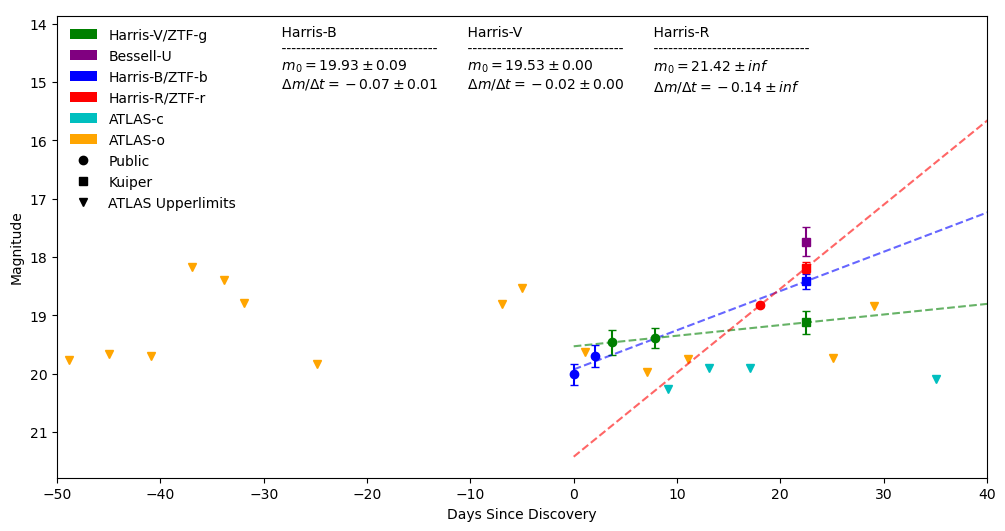

In [6]:
# just do the lightcurve cause it looks more informative
# I don't think the SED really shows anything...

fig, ax = plt.subplots(figsize=(12,6))

# public photometry
ddate = Time("2024-09-25 11:27:40.000", format="iso").mjd
for c, grp in public_phot.groupby("color"):
    ax.errorbar(grp.date-ddate, grp.mag, yerr=grp.mag_err, color=c, marker='o', linestyle='none', capsize=3)

# photometry from Kuiper
obsdate = Time("2024-10-18", format='iso').mjd
for _,row in data.iterrows():
    ax.errorbar(obsdate-ddate, row.mag, row.mag_err, color=color_map[row.FILTER], marker='s', linestyle='none', capsize=3)

# ATLAS photometry
for c, grp in atlas_phot.groupby("F"):
    if c == 'o': c='orange'
    ax.plot(grp[grp.upperlimit].mjd-ddate, grp[grp.upperlimit].mag5sig, color=c, marker='v', linestyle='none')
    ax.errorbar(grp[~grp.upperlimit].mjd-ddate, grp[~grp.upperlimit].mag, yerr=grp[~grp.upperlimit].mag_err, color=c, marker='o', linestyle='none', capsize=3)

# ZTF photometry
# for filt, grp in ztf_phot.groupby("filtercode"):
#     c = color_map[filt]
#     ax.plot(grp[grp.upperlimit].mjd-ddate, grp[grp.upperlimit].limitmag, color=c, marker='v', linestyle='none')
#     ax.errorbar(grp[~grp.upperlimit].mjd-ddate, grp[~grp.upperlimit].mag, yerr=grp[~grp.upperlimit].magerr, color=c, marker='o', linestyle='none')


ax.set_xlabel("Days Since Discovery")
ax2.set_xlabel(r"Wavelength [$\AA$]")
ax.set_ylabel("Magnitude")

color_labels = {
    "Harris-V/ZTF-g" : "g", # angstroms
    "Bessell-U": "purple",
    "Harris-B/ZTF-b" : "b",
    "Harris-R/ZTF-r" : "r",
    # "ZTF-i" : "brown,"
    "ATLAS-c" : "c",
    "ATLAS-o" : "orange"
}


ax.legend(
    handles=[
        Patch(facecolor=c, label=k) for k,c in color_labels.items()
    ] + [
        Line2D([0], [0], color='k', marker='o', label='Public', linestyle='none'),
        Line2D([0], [0], color='k', marker='s', label='Kuiper', linestyle='none'),
        Line2D([0], [0], color='k', marker='v', label='ATLAS Upperlimits', linestyle='none')
    ],
    loc="upper left",
    fancybox=False,
    frameon=False
)

# fit the detections with a simple linear power law
def linear_model(days, mag, mag0):
    return mag0 + days*mag

x0, y0 = -30, 13.75
for _, row in data.iterrows():
    mags = [row.mag] + list(public_phot[public_phot.color == color_map[row.FILTER]].mag)
    mags_err = [row.mag_err] + list(public_phot[public_phot.color == color_map[row.FILTER]].mag_err)
    mjd = np.array([obsdate] + list(public_phot[public_phot.color == color_map[row.FILTER]].date))-ddate
    
    if len(mjd) == 1: continue # skip fitting the Bessell-U because only one point
    
    popt, pcov = curve_fit(linear_model, mjd, mags, sigma=mags_err)
    perr = np.sqrt(np.diag(pcov))
    xdata = np.linspace(0, 50)
    yfit = linear_model(xdata, *popt)
    ax.plot(xdata, yfit, color=color_map[row.FILTER], linestyle='--', alpha=0.6)

    res_txt = rf"""
    {row.FILTER}
    --------------------------------
    $m_0 = {popt[1]:.2f} \pm {perr[1]:.2f}$
    $\Delta m/ \Delta t = {popt[0]:.2f} \pm {perr[0]:.2f}$
    """
    print(res_txt)
    print()

    ax.text(x0, y0, res_txt, verticalalignment="top", horizontalalignment="left")
    x0 += 18
    
ax.invert_yaxis()

ax.set_xlim(-50, 40)

fig.savefig("lightcurve.png")
